In [1]:
import os

# You can use 'tensorflow', 'torch' or 'jax' as backend. Make sure to set the environment variable before importing.
os.environ["KERAS_BACKEND"] = "tensorflow"

import mlflow
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms




mlflow.set_tracking_uri(uri="http://localhost:5000")



In [15]:
import keras_core


def initialize_model():
    INPUT_SHAPE = (100, 100, 1)  # Assuming grayscale images of 100x100 pixels
    model = keras_core.Sequential(
        [
            keras_core.layers.Input(shape=INPUT_SHAPE),
            keras_core.layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
            keras_core.layers.MaxPooling2D((2, 2)),
            # Add more Conv2D or MaxPooling2D layers as needed
            # keras_core.layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
            # keras_core.layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
            keras_core.layers.Flatten(),
            keras_core.layers.Dense(64, activation='relu'),
            keras_core.layers.Dense(6)  # Predicting 6 values for the vertices
        ]
    )
    return model

model = initialize_model()
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 98, 98, 32)        │        320 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 49, 49, 32)        │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ flatten_1 (Flatten)             │ (None, 76832)             │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_2 (Dense)                 │ (None, 64)                │  4,917,312 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_3 (Dense)                 │ (None, 6)                 │        390 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 4,918,022 (18.76 MB)

 Trainable params: 4,918,022 (18.76 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
from PIL import Image

def load_image(image_path, size=(100, 100)):
    with Image.open(image_path) as img:
        img = img.convert('L')  # Convert to grayscale
        img = img.resize(size)  # Resize image
        return np.array(img)

def load_dataset(dataset_path, labels, size=(100, 100)):
    num_samples = len(labels)
    # Assuming images are grayscale, adjust the shape accordingly
    # For RGB images, use size + (3,)
    images = np.zeros((num_samples, size[0], size[1]), dtype=np.float32)
    vertices = np.zeros((num_samples, 6), dtype=np.float32)  # Adjust size based on label structure

    for idx, label in enumerate(labels):
        img_path = os.path.join(dataset_path, label['file_name'])
        images[idx] = load_image(img_path, size=size) / 255.0  # Normalize images
        vertices[idx] = np.array(label['vertices']).flatten()

    return images, vertices


In [17]:
dataset_path = '/home/jay/repos/AI/data/triangles_dataset/'
labels = np.load(os.path.join(dataset_path, 'labels.npy'), allow_pickle=True)

images, vertices = load_dataset(dataset_path, labels)


In [36]:
import keras.backend as K

def custom_loss(y_true, y_pred):
    # Assuming the vertices are stored as (x1, y1, x2, y2, x3, y3)
    true_vertices = K.reshape(y_true, (-1, 3, 2))
    pred_vertices = K.reshape(y_pred, (-1, 3, 2))

    # Calculate the true and predicted centers
    true_center = K.mean(true_vertices, axis=1)
    pred_center = K.mean(pred_vertices, axis=1)

    # Calculate the distance between the true vertices and the predicted center
    center_distances = K.sqrt(K.sum(K.square(true_vertices - pred_center[:, None, :]), axis=-1))

    # The loss is the mean squared error of the vertices plus a penalty term for the center distances
    C=4
    vertex_loss = K.mean(K.square(y_true - y_pred), axis=-1)
    center_penalty = K.mean(center_distances, axis=-1)*C

    return vertex_loss + center_penalty

model.compile(
    optimizer='adam',
    loss=custom_loss,  # Example for a regression task
)

In [37]:
model.fit(
    x=images,
    y=vertices,
    batch_size=4,
    epochs=8,
    validation_split=0.1  # You can use validation split directly with NumPy arrays
)

Epoch 1/4
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 90s 39ms/step - loss: 346.2392 - val_loss: 416.8408
Epoch 2/4
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 104s 46ms/step - loss: 320.4002 - val_loss: 412.2255
Epoch 3/4
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 119s 53ms/step - loss: 284.9824 - val_loss: 392.8220
Epoch 4/4
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 119s 53ms/step - loss: 267.4816 - val_loss: 384.4464


In [20]:
mlflow.end_run()

In [38]:
import matplotlib.pyplot as plt
import torch
from scipy.optimize import linear_sum_assignment
from scipy.spatial.distance import cdist

def plot_vertices(image, real_vertices, predicted_vertices, calculate_distances):
    """
    Plot the image, real vertices, predicted vertices, and lines between predicted vertices and their closest real vertices.
    Annotate the lines with the calculated distances and display the sum of distances.

    Parameters:
    image (torch.Tensor or np.ndarray): The image tensor or numpy array.
    real_vertices (np.ndarray): Real vertices as a numpy array.
    predicted_vertices (np.ndarray): Predicted vertices as a numpy array.
    calculate_distances (function): Function to calculate distances and closest indices.
    """
    # Ensure real and predicted vertices are in the correct shape
    real_vertices = real_vertices.reshape((-1, 2))
    predicted_vertices = predicted_vertices.reshape((-1, 2))

    # Convert the image tensor to a numpy array for plotting
    if isinstance(image, torch.Tensor):
        image_np = image.detach().cpu().numpy().squeeze()  # Adjusted for potential tensor characteristics
    elif isinstance(image, np.ndarray):
        image_np = image
    else:
        raise TypeError("Image must be a torch.Tensor or np.ndarray.")
    
    # Calculate distances and closest indices using the provided function
    min_distances, closest_indices = calculate_distances(predicted_vertices, real_vertices)
    
    # Calculate the sum of the distances
    sum_of_distances = np.sum(min_distances)
    
    # Create the plot
    plt.figure(figsize=(10, 10))
    plt.imshow(image_np, cmap='gray')
    plt.scatter(real_vertices[:, 0], real_vertices[:, 1], color='green', label='Real Vertices')
    plt.scatter(predicted_vertices[:, 0], predicted_vertices[:, 1], color='red', label='Predicted Vertices')
    
    # Draw lines and annotate distances
    for i, (dist, closest_idx) in enumerate(zip(min_distances, closest_indices)):
        pred_vertex = predicted_vertices[i]
        closest_real_vertex = real_vertices[closest_idx]
        plt.plot([pred_vertex[0], closest_real_vertex[0]], [pred_vertex[1], closest_real_vertex[1]], 'b--')
        mid_point = (pred_vertex + closest_real_vertex) / 2
        plt.text(mid_point[0], mid_point[1], f'{dist:.2f}', color='blue')
    
    # Display the sum of distances
    plt.title(f'Sum of Distances: {sum_of_distances:.2f}')
    plt.legend()
    plt.show()


def calculate_distances(predicted_vertices, real_vertices):

    """
    Calculate the distance from each predicted vertex to the nearest real vertex,
    ensuring that no two predicted vertices are paired with the same real vertex.

    Parameters:
    predicted_vertices (np.ndarray): 2D array of predicted vertices [N, 2].
    real_vertices (np.ndarray): 2D array of real vertices [M, 2].

    Returns:
    tuple: A tuple containing:
        - distances (np.ndarray): The distances of predicted vertices to their assigned real vertex.
        - assignment_indices (np.ndarray): The indices of the real vertices assigned to each predicted vertex.
    """
    # Calculate all pairwise distances
    distances = cdist(predicted_vertices, real_vertices)
    
    # Solve the assignment problem
    predicted_indices, real_indices = linear_sum_assignment(distances)
    
    # Calculate the minimum distances based on the optimal assignment
    min_distances = distances[predicted_indices, real_indices]
    
    return min_distances, real_indices




1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


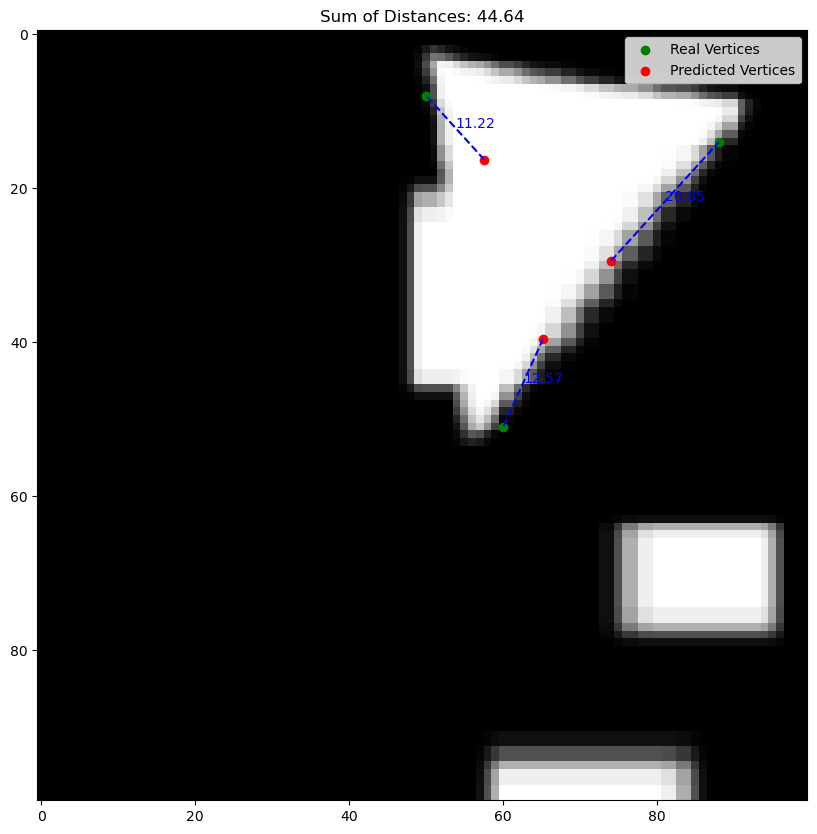

In [55]:
random_index = np.random.randint(0, len(images))
plot_vertices(images[random_index], vertices[random_index], model.predict(images[random_index][None, ...]), calculate_distances)